# Implementation of Optimised RLE

In [58]:
!pip install opencv-python

In [64]:
from PIL import Image
import numpy as np
import cv2
import os
import time
from google.colab.patches import cv2_imshow

**Google Drive Link of 'Penguin.png':** [Link](https://drive.google.com/file/d/1bWtE9E-ualct6x2mdQbRKfO5L6i0aGtA/view)

In [29]:
def automatic_thresholding(image):
    # Calculate threshold value using automatic thresholding
    min_val = np.min(image)
    max_val = np.max(image)
    threshold = (min_val + max_val) * 0.5
    return threshold

def sign_change(image):
    # Calculate sign change values for rows and columns
    row_changes = np.sum(np.abs(np.diff(image, axis=1)) > 0, axis=1)
    col_changes = np.sum(np.abs(np.diff(image, axis=0)) > 0, axis=0)
    return row_changes, col_changes

def encode_row(row):
    encoded_row = []
    count = 0
    for i in range(len(row)):
        if i == 0 or row[i] != row[i-1]:
            if count > 0:
                encoded_row.append(count)
            encoded_row.append(row[i])
            count = 1
        else:
            count += 1
    if count > 0:
        encoded_row.append(count)
    return encoded_row

def encode_image(image):
    encoded_image = []
    for row in image:
        encoded_row = encode_row(row)
        encoded_image.append(encoded_row)
    return encoded_image

1. **Automatic Thresholding**:
   This function calculates the threshold value of an image using an automatic thresholding technique. It determines the minimum and maximum intensity values in the image and computes the threshold as the average of these two values.

2. **Sign Change Calculation**:
   This function computes the number of sign changes in neighboring intensity values for each row and column of the image. It calculates the sign change values by taking the absolute difference between adjacent pixel values along rows and columns and counting the instances where this difference is greater than zero.

3. **Run-Length Encoding (RLE)**:
   The `encode_row` function encodes a single row of the image using RLE. It iterates through the row, counting consecutive instances of the same intensity value and storing them as a value-frequency pair in the encoded row.

   The `encode_image` function applies the `encode_row` function to each row of the image, producing the encoded image in RLE format.

In [30]:
def compress_image(image_path):
    # Read input image
    img = Image.open(image_path)
    img = img.convert('RGB')
    img_array = np.array(img)

    # Convert to grayscale if necessary
    if len(img_array.shape) > 2:
        img_array = np.mean(img_array, axis=2)

    # Automatic thresholding
    threshold = automatic_thresholding(img_array)

    # Orientation check
    if img_array.shape[0] >= img_array.shape[1]:
        img_array = np.transpose(img_array)
        flag1 = True
    else:
        flag1 = False

    # Sign change calculation
    row_changes, col_changes = sign_change(img_array)
    RSC = np.sum(row_changes)
    CSC = np.sum(col_changes)
    μ = (RSC - CSC) / RSC

    # Set flag2 based on orientation
    if μ > 0.75:
        flag2 = True
        img_array = np.transpose(img_array)
    else:
        flag2 = False

    # Encode the image
    encoded_image = encode_image(img_array)

    return encoded_image, flag1, flag2

def write_to_text(encoded_image, output_file):
    with open(output_file, 'w') as f:
        for row in encoded_image:
            int_row = [int(num) for num in row]  # Convert to integers
            f.write(' '.join(map(str, int_row)) + '\n')

def compress_image_and_write(image_path, output_text_file):
    encoded_image, flag1, flag2 = compress_image(image_path)
    write_to_text(encoded_image, output_text_file)
    return flag1, flag2

1. **Image Compression**:
   - The `compress_image` function reads an input image using the `Image.open` function from the PIL library.
   - It converts the image to RGB format and then converts it to a NumPy array.
   - If the image is in color (i.e., has more than one channel), it converts it to grayscale using the mean of the RGB channels.
   - Automatic thresholding is applied to determine a suitable threshold value for the image.
   - Orientation check is performed to determine if the image is in landscape or portrait orientation. If necessary, the image is transposed.
   - Sign change calculation is performed to analyze the changes in intensity values along rows and columns of the image.
   - Based on the orientation and the sign change ratio, flags (`flag1` and `flag2`) are set to determine whether the image needs to be transposed again during decompression.
   - The image is then encoded using the `encode_image` function.

2. **Writing to Text File**:
   - The `write_to_text` function writes the encoded image data to a text file in a readable format.
   - It converts each element of the encoded image to integers before writing them to the file to ensure compatibility with the decoding process.

3. **Compression and Writing**:
   - The `compress_image_and_write` function combines the compression and writing steps.
   - It calls the `compress_image` function to compress the input image and obtain the encoded image data along with flags.
   - The encoded image data and flags are then written to the specified text file using the `write_to_text` function.


In [31]:
def display_encoded_image(input_file, output_image_file):
    decoded_data = []
    with open(input_file, 'r') as file:
        lines = file.readlines()

    for line in lines:
        encoded_row = [int(x) for x in line.split()]
        decoded_row = []
        for i in range(0, len(encoded_row), 2):
            pixel_value = encoded_row[i]
            decoded_row.append(pixel_value)
        decoded_data.append(decoded_row)

    max_length = max(len(row) for row in decoded_data)
    padded_data = []
    for row in decoded_data:
        padded_row = row + [row[-1]] * (max_length - len(row))
        padded_data.append(padded_row)

    image_data = np.array(padded_data, dtype=np.uint8)
    cv2.imwrite(output_image_file, image_data)

1. **Reading Encoded Image Data**:
   - The function reads the encoded image data from the input text file (`input_file`) line by line using the `readlines()` function.
   - Each line represents a row of the encoded image data, where consecutive elements represent pixel values and their frequencies.

2. **Decoding Image Data**:
   - For each line of the encoded image data, the function splits it into individual elements and converts them to integers.
   - It then iterates through the elements, extracting pixel values and ignoring their frequencies to decode the image data.
   - Decoded pixel values are stored row by row in a list (`decoded_data`).

3. **Padding Rows**:
   - Since each row of the encoded image may have a different length due to run-length encoding, the function pads shorter rows with the last pixel value to ensure all rows have the same length.
   - This padding ensures consistency when converting the decoded image data into a NumPy array.

4. **Converting to NumPy Array and Saving Image**:
   - The function converts the decoded image data into a NumPy array of unsigned integers (`dtype=np.uint8`) to represent pixel values.
   - The NumPy array is then saved as an image file (e.g., PNG) using the `cv2.imwrite` function, with the specified output image file path (`output_image_file`).

In [68]:
start_time = time.time()
input_image_path = "Penguin.png"
output_text_file = "encoded_image.txt"

flag1, flag2 = compress_image_and_write(input_image_path, output_text_file)
compression_time = time.time() - start_time

print("Compression completed. File Stored Named as 'encoded_image.txt'")
print("Flag1:", flag1)
print("Flag2:", flag2)

Compression completed. File Stored Named as 'encoded_image.txt'
Flag1: False
Flag2: False


In [69]:
def decode_row(encoded_row):
    decoded_row = []
    for i in range(0, len(encoded_row), 2):
        intensity = encoded_row[i]
        frequency = encoded_row[i+1] if i+1 < len(encoded_row) else 1
        decoded_row.extend([intensity] * frequency)
    return decoded_row

def decode_image(encoded_image):
    decoded_image = []
    for encoded_row in encoded_image:
        decoded_row = decode_row(encoded_row)
        decoded_image.append(decoded_row)
    return decoded_image

def decompress_text(input_text_file):
    encoded_image = []
    with open(input_text_file, 'r') as f:
        for line in f:
            encoded_row = list(map(int, line.strip().split()))
            encoded_image.append(encoded_row)
    return encoded_image

def decompress_image(encoded_image, flag1, flag2):
    decoded_image = decode_image(encoded_image)

    # Perform transpose if necessary based on flags
    if flag1 ^ flag2:
        decoded_image = np.transpose(decoded_image)

    return decoded_image

1. **`decode_row(encoded_row)`**:
   - This function decodes a single row of the encoded image data.
   - It iterates through the elements of the encoded row, where consecutive pairs represent pixel intensity values and their frequencies.
   - For each pair, it extracts the intensity value (`intensity`) and the frequency (`frequency`), using a default frequency of 1 if no frequency is provided.
   - It then extends the decoded row with the intensity value repeated `frequency` times, effectively reconstructing the original row of pixel values.

2. **`decode_image(encoded_image)`**:
   - This function decodes the entire encoded image by applying `decode_row` to each row of the encoded image data.
   - It iterates through each row of the encoded image, decoding it using `decode_row`, and appends the decoded row to the `decoded_image`.

3. **`decompress_text(input_text_file)`**:
   - This function reads the encoded image data from a text file (`input_text_file`).
   - It reads each line of the text file, representing a row of the encoded image, and splits it into individual elements.
   - It converts each element to an integer and appends the resulting list (representing an encoded row) to `encoded_image`.

4. **`decompress_image(encoded_image, flag1, flag2)`**:
   - This function orchestrates the decompression process by decoding the encoded image data and applying necessary transformations based on orientation flags.
   - It first decodes the encoded image using `decode_image`.
   - It checks the flags (`flag1` and `flag2`) to determine if any transpose operations are required during decompression.
   - If `flag1` and `flag2` are not equal (i.e., their XOR operation results in True), indicating a mismatch in orientation, it transposes the decoded image using `np.transpose`.

Encoded Image:


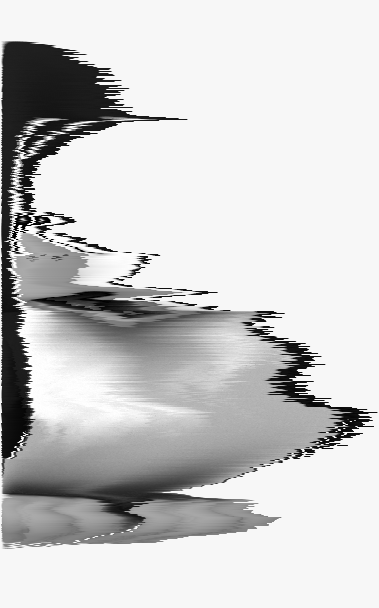

In [70]:
compressed_image = 'encoded_image.png'
display_encoded_image(output_text_file, compressed_image)

print("Encoded Image:")
encoded_img = cv2.imread(compressed_image, cv2.IMREAD_UNCHANGED)
cv2_imshow(encoded_img)

Decoded Image: 


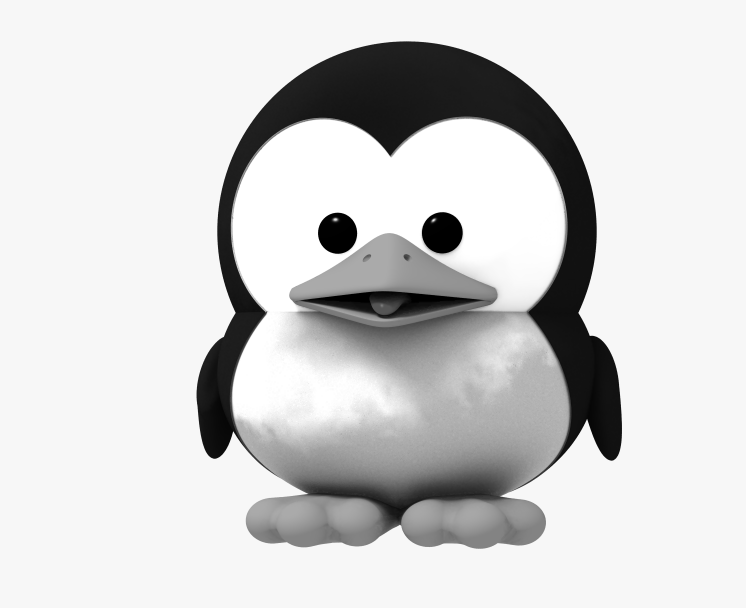

In [71]:
input_text_file = "encoded_image.txt"

# Read the encoded image from the text file
decoded_image = decompress_text(input_text_file)

decoded_image_file = 'decoded_image.png'
decoded_image = decompress_image(decoded_image, flag1, flag2)

print("Decoded Image: ")
decoded_image_np = np.array(decoded_image, dtype=np.uint8)
cv2.imwrite(decoded_image_file, decoded_image_np)
cv2_imshow(decoded_image_np)

In [72]:
#Print encoding results

input_size = os.path.getsize(input_image_path)
compressed_size = os.path.getsize(compressed_image)
compression_ratio = input_size / compressed_size

print("Size of Input image:", input_size, "bytes")
print("Size of encoded image", compressed_size, "bytes")
print("Compression Ratio:", compression_ratio)
print("Compression Time:", compression_time, "seconds")

Size of Input image: 158754 bytes
Size of encoded image 47976 bytes
Compression Ratio: 3.3090295147573787
Compression Time: 0.5097792148590088 seconds
